In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

In [123]:
device = 'cuda'

# Attention Rollout

## AG News

In [124]:
train_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=2000)

test_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'test')

In [5]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [6]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Understanding layer names

In [8]:
for name, module in model.named_modules():
    print(name)


bert
bert.embeddings
bert.embeddings.word_embeddings
bert.embeddings.position_embeddings
bert.embeddings.token_type_embeddings
bert.embeddings.LayerNorm
bert.embeddings.dropout
bert.encoder
bert.encoder.layer
bert.encoder.layer.0
bert.encoder.layer.0.attention
bert.encoder.layer.0.attention.self
bert.encoder.layer.0.attention.self.query
bert.encoder.layer.0.attention.self.key
bert.encoder.layer.0.attention.self.value
bert.encoder.layer.0.attention.self.dropout
bert.encoder.layer.0.attention.output
bert.encoder.layer.0.attention.output.dense
bert.encoder.layer.0.attention.output.LayerNorm
bert.encoder.layer.0.attention.output.dropout
bert.encoder.layer.0.intermediate
bert.encoder.layer.0.intermediate.dense
bert.encoder.layer.0.intermediate.intermediate_act_fn
bert.encoder.layer.0.output
bert.encoder.layer.0.output.dense
bert.encoder.layer.0.output.LayerNorm
bert.encoder.layer.0.output.dropout
bert.encoder.layer.1
bert.encoder.layer.1.attention
bert.encoder.layer.1.attention.self
bert.e

### Most important tokens before and after training

In [107]:
batch_size = 32

In [108]:
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [139]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [140]:
attentions = []
all_tokens = []
all_labels = []
for row in tqdm(train_dataloader):
    tokens = tokenizer(
        row['text'], 
        return_tensors='pt',
        padding = 'longest'
    )

    out, attn_matrix = metric(**tokens.to(device), output_attentions = True)

    for i in range(batch_size):
        try:
            nonzero_idx = (tokens['input_ids'][i] == 0).nonzero()
            if len(nonzero_idx) == 0:
                attentions.append(attn_matrix[i])

            else:
                last_idx = nonzero_idx[0].item()
                attentions.append(attn_matrix[i, :last_idx, :last_idx])

            all_tokens.append(tokens['input_ids'][i])

            all_labels.append(row['label'][i])
        except:
            pass

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:08<00:00,  7.35it/s]


In [141]:
best_word_dict = []

for i in range(len(all_tokens)):
    topk_indexes = torch.topk(attentions[i][0], k =10).indices[2:]
    best_words = tokenizer.decode(all_tokens[i][topk_indexes])

    best_word_dict.append({
        'words': best_words,
        'label' : all_labels[i].item(),
    })



In [142]:
best_words_per_class = pd.DataFrame(best_word_dict)\
    .groupby('label')\
    .words\
    .sum()

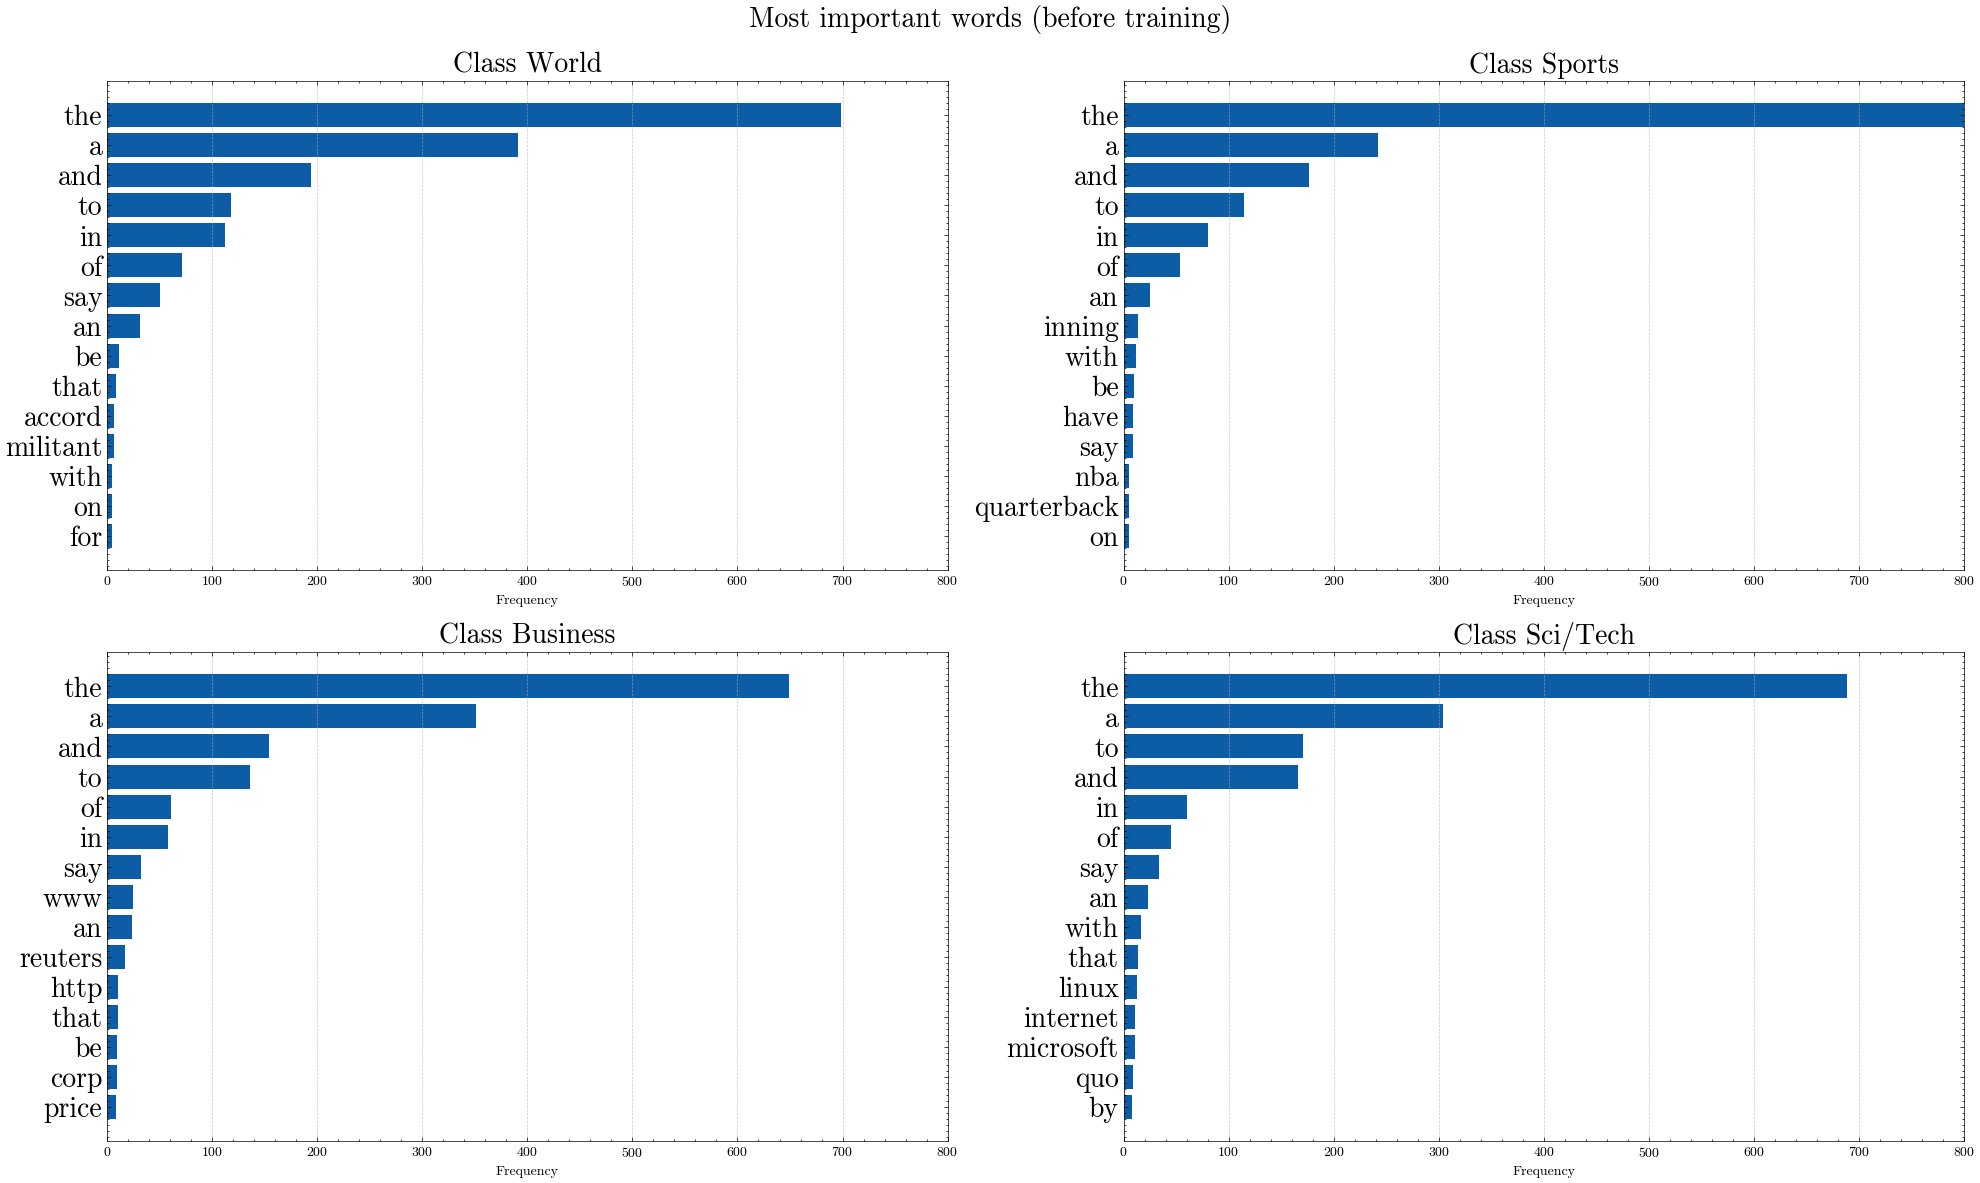

In [144]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for c in range(n_classes):
    most_frequent = lemmatize_text((remove_punctuation(best_words_per_class[c])))
    sorted_frequencies = sorted(get_word_frequencies(most_frequent), key = lambda x: x[1], reverse=True)[0:15]
    
    words, frequencies = zip(*sorted_frequencies)

    # Create the bar plot
    axes[c].barh(words[::-1], frequencies[::-1])  # Reverse order for better visualization
    axes[c].set_xlabel("Frequency")
    axes[c].set_ylabel("")
    axes[c].set_title(f"Class {label_names[c]}", fontsize= 20) 
    axes[c].grid(axis="x", linestyle="--", alpha=0.7)
    axes[c].tick_params(axis='y', labelsize=20)

    axes[c].set_xlim([0, 800])

fig.suptitle("Most important words (before training)", y = 0.99, fontsize = 20)
plt.tight_layout()
plt.show()

### After training

In [125]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained(
    "peulsilva/bert-ag_news", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [126]:
batch_size = 32

In [127]:
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [145]:
metric_finetune = AttentionRollout(finetuned_model, attention_layer_name='attention')

In [146]:
attentions = []
all_tokens = []
all_labels = []
for row in tqdm(train_dataloader):
    tokens = tokenizer(
        row['text'], 
        return_tensors='pt',
        padding = 'longest'
    )

    out, attn_matrix = metric_finetune(**tokens.to(device), output_attentions = True)

    for i in range(batch_size):
        try:
            nonzero_idx = (tokens['input_ids'][i] == 0).nonzero()
            if len(nonzero_idx) == 0:
                attentions.append(attn_matrix[i])

            else:
                last_idx = nonzero_idx[0].item()
                attentions.append(attn_matrix[i, :last_idx, :last_idx])

            all_tokens.append(tokens['input_ids'][i])

            all_labels.append(row['label'][i])
        except:
            pass

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:07<00:00,  7.93it/s]


In [148]:
best_word_dict = []

for i in range(len(all_tokens)):
    topk_indexes = torch.topk(attentions[i][0], k =10).indices[2:]
    best_words = tokenizer.decode(all_tokens[i][topk_indexes])

    best_word_dict.append({
        'words': best_words,
        'label' : all_labels[i].item(),
    })



In [149]:
best_words_per_class = pd.DataFrame(best_word_dict)\
    .groupby('label')\
    .words\
    .sum()

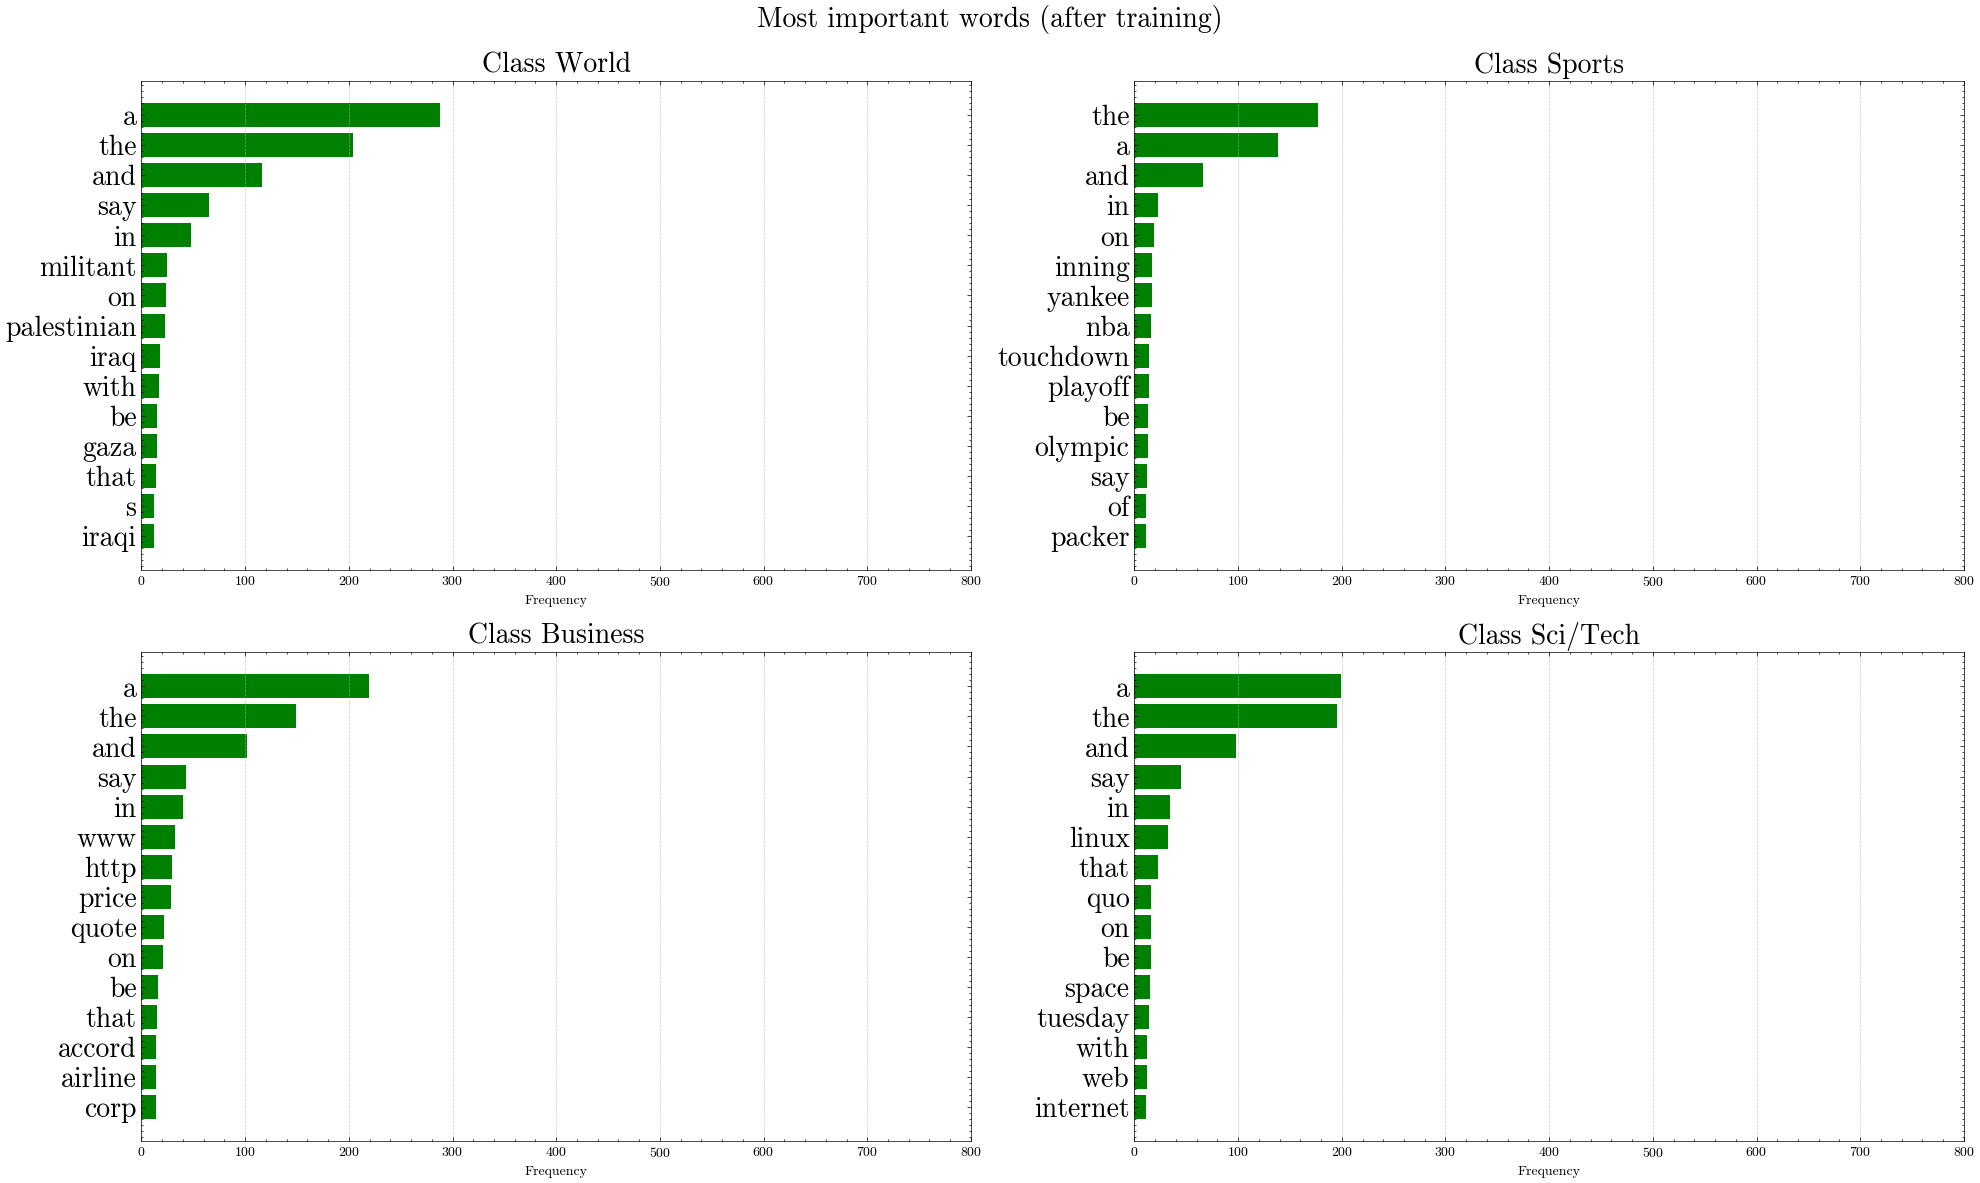

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for c in range(n_classes):
    most_frequent = lemmatize_text((remove_punctuation(best_words_per_class[c])))
    sorted_frequencies = sorted(get_word_frequencies(most_frequent), key = lambda x: x[1], reverse=True)[0:15]
    
    words, frequencies = zip(*sorted_frequencies)

    # Create the bar plot
    axes[c].barh(words[::-1], frequencies[::-1], color = 'green')  # Reverse order for better visualization
    axes[c].set_xlabel("Frequency")
    axes[c].set_ylabel("")
    axes[c].set_title(f"Class {label_names[c]}", fontsize= 20) 
    axes[c].grid(axis="x", linestyle="--", alpha=0.7)
    axes[c].tick_params(axis='y', labelsize=20)
    axes[c].set_xlim([0,800])

fig.suptitle("Most important words (after training)", y = 0.99, fontsize = 20)
plt.tight_layout()
plt.show()